In [1]:
import pandas as pd
import numpy as np

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.model_selection import TimeSeriesSplit

from fbprophet import Prophet

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
organic = pd.read_csv('organic.csv',index_col = 0)

In [8]:
organic.head()

,AveragePrice,Total Volume,small,medium,large,type,year,region
Date,,,,,,,,
2015-12-27,1.83,989.55,8.16,88.59,0.0,organic,2015,NY
2015-12-20,1.89,1163.03,30.24,172.14,0.0,organic,2015,NY
2015-12-13,1.85,995.96,10.44,178.70,0.0,organic,2015,NY
2015-12-06,1.84,1158.42,90.29,104.18,0.0,organic,2015,NY
2015-11-29,1.94,831.69,0.00,94.73,0.0,organic,2015,NY


In [142]:
conventional = pd.read_csv('conventional.csv',index_col = 0)

# California

**Organic**
1. Make data frame for prophet

In [172]:
ca_org = pd.DataFrame(organic[organic['region'] == 'CA'].groupby('Date')['AveragePrice'].mean())

In [173]:
ca_org.reset_index('Date', inplace = True)
ca_org.rename(columns = {'Date': 'ds', 'AveragePrice': 'y'}, inplace = True)

In [174]:
ca_org['ds'] = pd.to_datetime(ca_org['ds'], format='%Y-%m-%d')

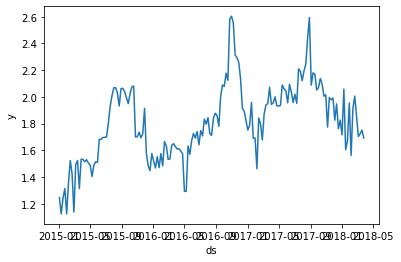

In [175]:
sns.lineplot(x = ca_org['ds'], y = ca_org['y'])

# Train/Split

In [176]:
tss_ca = TimeSeriesSplit(n_splits = 2)

X_org_ca = ca_org['ds'].values
y_org_ca = ca_org['y'].values

for train_index, test_index in tss_ca.split(X_org_ca):
#     print("TRAIN:", train_index, "TEST:", test_index)
    X_org_ca_train, X_org_ca_test = X_org_ca[train_index], X_org_ca[test_index]
    y_org_ca_train, y_org_ca_test = y_org_ca[train_index], y_org_ca[test_index]

org_ca_train = pd.DataFrame(y_org_ca_train,index = X_org_ca_train, columns = ['y'])
org_ca_test = pd.DataFrame(y_org_ca_test, index = X_org_ca_test, columns = ['y'])
org_ca_train.head()


,y
2015-01-04,1.246
2015-01-11,1.124
2015-01-18,1.244
2015-01-25,1.314
2015-02-01,1.124


In [177]:
org_ca_train.reset_index(inplace = True)
org_ca_train.rename(columns = {'index':'ds'},inplace = True)

In [178]:
#Run a prophet model on data
ca_con_prophet = Prophet(interval_width = 0.95, changepoint_prior_scale = 0.01).fit(org_ca_train)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/opt/anaconda3/lib/python3.7/site-packages/pystan/misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



RMSE in cents:  0.2241746322479453


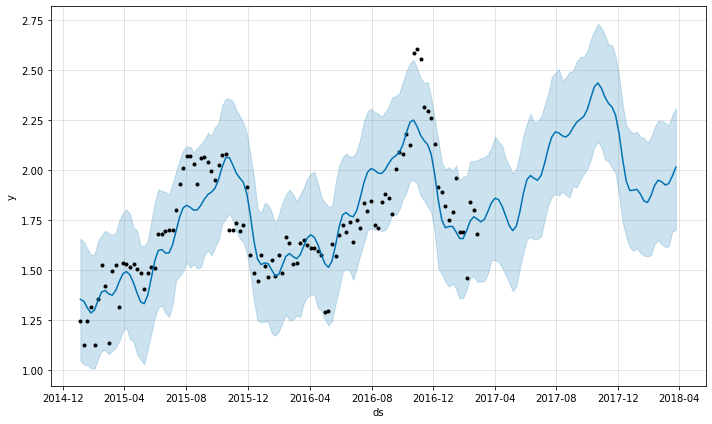

In [179]:
#predict our test data
future_org_ca = ca_con_prophet.make_future_dataframe(periods=56,freq = 'W')
forecast_org_ca = ca_con_prophet.predict(future_org_ca)

fig1_org_ca = ca_con_prophet.plot(forecast_org_ca)

preds_org_ca = forecast_org_ca.iloc[113:][['ds','yhat']].set_index('ds')
preds_org_ca.head()

preds_org_ca_df = pd.concat([org_ca_test,preds_org_ca],axis = 1)
preds_org_ca_df.head()

error = np.sqrt(sum((preds_org_ca_df['y'] - preds_org_ca_df['yhat'])**2)/len(preds_org_ca_df))
print('RMSE in cents: ',error)

Text(0.5, 1.0, 'Prophet Predictions for Organic')

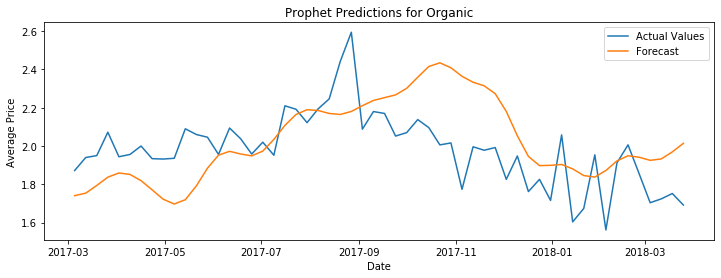

In [180]:
fig, ax = plt.subplots(figsize=(12,4))
ax1 = sns.lineplot(x=preds_org_ca_df.index, y=preds_org_ca_df['y'], label='Actual Values')
ax2 = sns.lineplot(x=preds_org_ca_df.index, y=preds_org_ca_df['yhat'], label='Forecast')

plt.ylabel('Average Price')
plt.xlabel('Date')
plt.title('Prophet Predictions for Organic')
# plt.savefig('Images/prophet_org.png', dpi=300)

**Conventional**

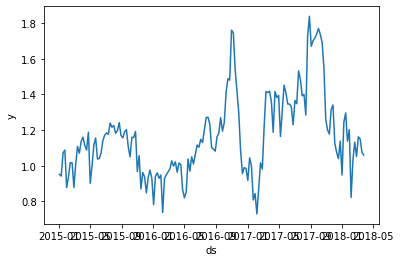

In [185]:
ca_con = pd.DataFrame(conventional[conventional['region'] == 'CA'].groupby('Date')['AveragePrice'].mean())

ca_con.reset_index('Date', inplace = True)
ca_con.rename(columns = {'Date': 'ds', 'AveragePrice': 'y'}, inplace = True)

# ca['ds'] = pd.to_datetime(ca['ds'])
ca_con['ds'] = pd.to_datetime(ca_con['ds'], format='%Y-%m-%d')

sns.lineplot(x = ca_con['ds'], y = ca_con['y'])

In [186]:
# Train/Split
tss_ca = TimeSeriesSplit(n_splits = 2)

X_con_ca = ca_con['ds'].values
y_con_ca = ca_con['y'].values

for train_index, test_index in tss_ca.split(X_con_ca):
#     print("TRAIN:", train_index, "TEST:", test_index)
    X_con_ca_train, X_con_ca_test = X_con_ca[train_index], X_con_ca[test_index]
    y_con_ca_train, y_con_ca_test = y_con_ca[train_index], y_con_ca[test_index]

con_ca_train = pd.DataFrame(y_con_ca_train,index = X_con_ca_train, columns = ['y'])
con_ca_test = pd.DataFrame(y_con_ca_test, index = X_con_ca_test, columns = ['y'])
con_ca_train.head()


con_ca_train.reset_index(inplace = True)
con_ca_train.rename(columns = {'index':'ds'},inplace = True)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/opt/anaconda3/lib/python3.7/site-packages/pystan/misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



RMSE in cents:  0.27530031448720144


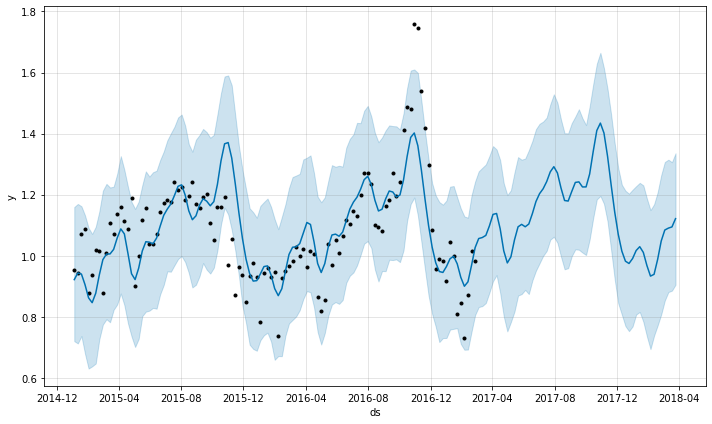

In [189]:
ca_con_prophet = Prophet(interval_width = 0.95, changepoint_prior_scale = 0.01).fit(con_ca_train)

future_con_ca = ca_con_prophet.make_future_dataframe(periods=56,freq = 'W')
forecast_con_ca = ca_con_prophet.predict(future_con_ca)
forecast_con_ca.tail()

fig1_con_ca = ca_con_prophet.plot(forecast_con_ca)

preds_con_ca = forecast_con_ca.iloc[113:][['ds','yhat']].set_index('ds')
preds_con_ca.head()

preds_con_ca_df = pd.concat([con_ca_test,preds_con_ca],axis = 1)
preds_con_ca_df.head()

error = np.sqrt(sum((preds_con_ca_df['y'] - preds_con_ca_df['yhat'])**2)/len(preds_con_ca_df))
print('RMSE in cents: ',error)


Text(0.5, 1.0, 'Prophet Predictions for Conventional in California')

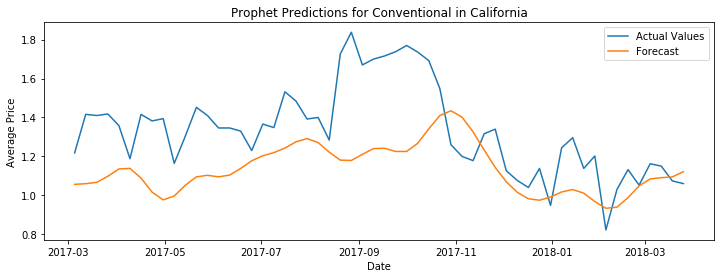

In [190]:
fig, ax = plt.subplots(figsize=(12,4))
ax1 = sns.lineplot(x=preds_con_ca_df.index, y=preds_con_ca_df['y'], label='Actual Values')
ax2 = sns.lineplot(x=preds_con_ca_df.index, y=preds_con_ca_df['yhat'], label='Forecast')

plt.ylabel('Average Price')
plt.xlabel('Date')
plt.title('Prophet Predictions for Conventional in California')
# plt.savefig('Images/prophet_con_ca.png', dpi=300)

Text(0.5, 1.0, 'Prophet Predictions for Conventional in California')

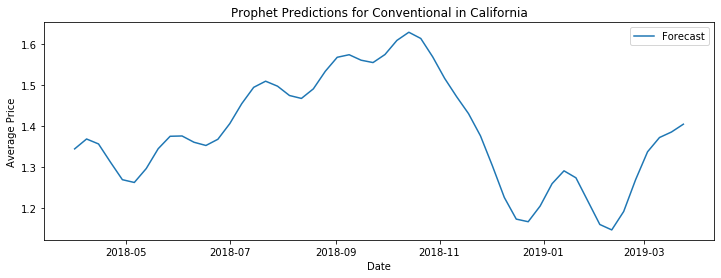

In [207]:
ca_con_prophet = Prophet(interval_width = 0.95, changepoint_prior_scale = 0.01).fit(ca_con)
future_con_ca = ca_con_prophet.make_future_dataframe(periods=116,freq = 'W')
forecast_con_ca = ca_con_prophet.predict(future_con_ca)

preds_con_ca = forecast_con_ca.iloc[170:][['ds','yhat']].set_index('ds')

fig, ax = plt.subplots(figsize=(12,4))
ax2 = sns.lineplot(x=preds_con_ca.index, y=preds_con_ca['yhat'], label='Forecast')

plt.ylabel('Average Price')
plt.xlabel('Date')
plt.title('Prophet Predictions for Conventional in California')
# plt.savefig('Images/prophet_con_ca.png', dpi=300)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/opt/anaconda3/lib/python3.7/site-packages/pystan/misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



169

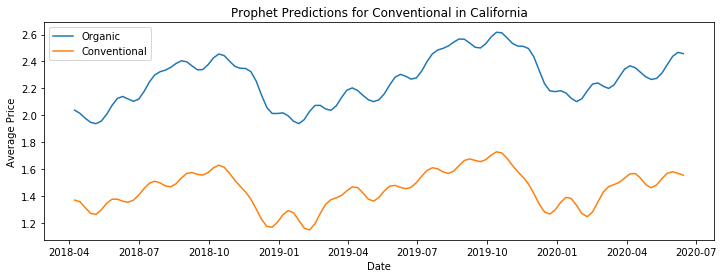

In [216]:
ca_org_prophet = Prophet(interval_width = 0.95, changepoint_prior_scale = 0.01).fit(ca_org)
future_org_ca = ca_org_prophet.make_future_dataframe(periods=116,freq = 'W')
forecast_org_ca = ca_org_prophet.predict(future_org_ca)

preds_org_ca = forecast_org_ca.iloc[170:][['ds','yhat']].set_index('ds')
preds_org_ca.head()

preds_org_ca.tail()

ca_org.tail()

len(ca_org)

Text(0.5, 1.0, 'Prophet Predictions for Hass Avocados in California')

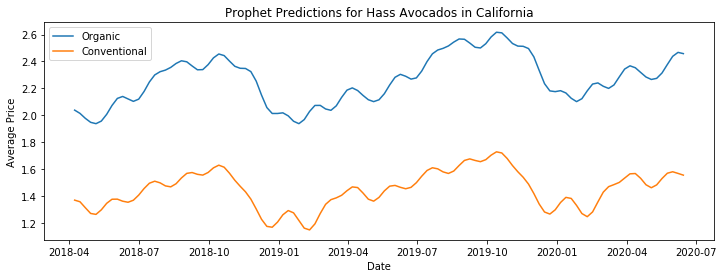

In [218]:
fig, ax = plt.subplots(figsize=(12,4))
ax2 = sns.lineplot(x=preds_org_ca.index, y=preds_org_ca['yhat'], label='Organic')
ax1 = sns.lineplot(x=preds_con_ca.index, y=preds_con_ca['yhat'], label='Conventional')


plt.ylabel('Average Price')
plt.xlabel('Date')
plt.title('Prophet Predictions for Hass Avocados in California')
# plt.savefig('Images/prophet_con_ca.png', dpi=300)

# Georgia

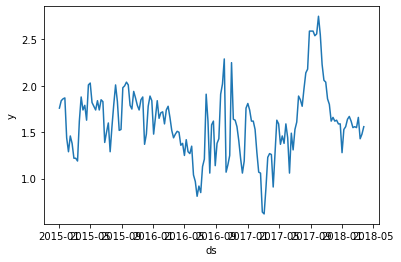

In [272]:
ga_org = pd.DataFrame(organic[organic['region'] == 'GA'].groupby('Date')['AveragePrice'].mean())

ga_org.reset_index('Date', inplace = True)
ga_org.rename(columns = {'Date': 'ds', 'AveragePrice': 'y'}, inplace = True)

ga_org['ds'] = pd.to_datetime(ga_org['ds'], format='%Y-%m-%d')

sns.lineplot(x = ga_org['ds'], y = ga_org['y'])

In [273]:
# Train/Split

tss_ga = TimeSeriesSplit(n_splits = 2)

X_org_ga = ga_org['ds'].values
y_org_ga = ga_org['y'].values

for train_index, test_index in tss_ga.split(X_org_ga):
    X_org_ga_train, X_org_ga_test = X_org_ga[train_index], X_org_ga[test_index]
    y_org_ga_train, y_org_ga_test = y_org_ga[train_index], y_org_ga[test_index]

org_ga_train = pd.DataFrame(y_org_ga_train,index = X_org_ga_train, columns = ['y'])
org_ga_test = pd.DataFrame(y_org_ga_test, index = X_org_ga_test, columns = ['y'])

org_ga_train.reset_index(inplace = True)
org_ga_train.rename(columns = {'index':'ds'},inplace = True)


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/opt/anaconda3/lib/python3.7/site-packages/pystan/misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



RMSE in cents:  0.6627004415660349


Text(0.5, 1.0, 'Prophet Predictions for Organic')

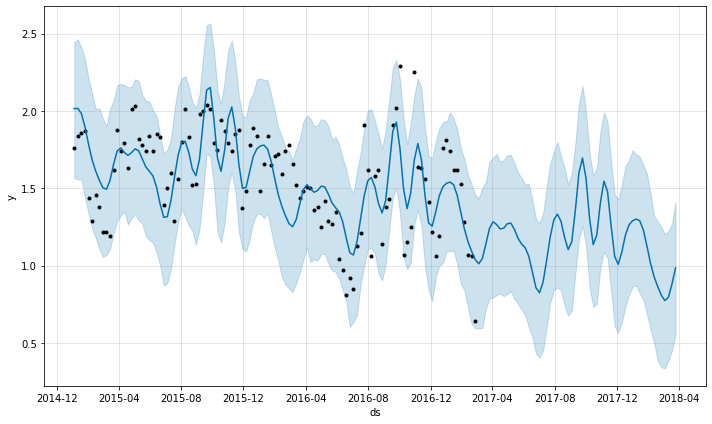

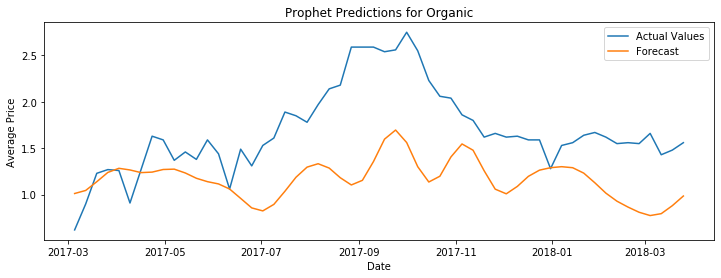

In [274]:
ga_con_prophet = Prophet(interval_width = 0.95, changepoint_prior_scale = 0.05).fit(org_ga_train)

future_org_ga = ga_con_prophet.make_future_dataframe(periods=56,freq = 'W')
forecast_org_ga = ga_con_prophet.predict(future_org_ga)
forecast_org_ga.tail()

fig1_org_ga = ga_con_prophet.plot(forecast_org_ga)

preds_org_ga = forecast_org_ga.iloc[113:][['ds','yhat']].set_index('ds')
preds_org_ga.head()

preds_org_ga_df = pd.concat([org_ga_test,preds_org_ga],axis = 1)
preds_org_ga_df.head()

error = np.sqrt(sum((preds_org_ga_df['y'] - preds_org_ga_df['yhat'])**2)/len(preds_org_ga_df))
print('RMSE in cents: ',error)


fig, ax = plt.subplots(figsize=(12,4))
ax1 = sns.lineplot(x=preds_org_ga_df.index, y=preds_org_ga_df['y'], label='Actual Values')
ax2 = sns.lineplot(x=preds_org_ga_df.index, y=preds_org_ga_df['yhat'], label='Forecast')

plt.ylabel('Average Price')
plt.xlabel('Date')
plt.title('Prophet Predictions for Organic')
# plt.savefig('Images/prophet_org.png', dpi=300)

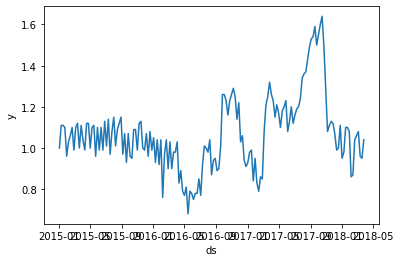

In [275]:
ga_con = pd.DataFrame(conventional[conventional['region'] == 'GA'].groupby('Date')['AveragePrice'].mean())

ga_con.reset_index('Date', inplace = True)
ga_con.rename(columns = {'Date': 'ds', 'AveragePrice': 'y'}, inplace = True)

ga_con['ds'] = pd.to_datetime(ga_con['ds'], format='%Y-%m-%d')

sns.lineplot(x = ga_con['ds'], y = ga_con['y'])

In [276]:
# Train/Split
tss_ga = TimeSeriesSplit(n_splits = 2)

X_con_ga = ga_con['ds'].values
y_con_ga = ga_con['y'].values

for train_index, test_index in tss_ga.split(X_con_ga):
    X_con_ga_train, X_con_ga_test = X_con_ga[train_index], X_con_ga[test_index]
    y_con_ga_train, y_con_ga_test = y_con_ga[train_index], y_con_ga[test_index]

con_ga_train = pd.DataFrame(y_con_ga_train,index = X_con_ga_train, columns = ['y'])
con_ga_test = pd.DataFrame(y_con_ga_test, index = X_con_ga_test, columns = ['y'])

con_ga_train.reset_index(inplace = True)
con_ga_train.rename(columns = {'index':'ds'},inplace = True)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/opt/anaconda3/lib/python3.7/site-packages/pystan/misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



RMSE in cents:  0.2882247901137827


Text(0.5, 1.0, 'Prophet Predictions for Conventional in Georgia')

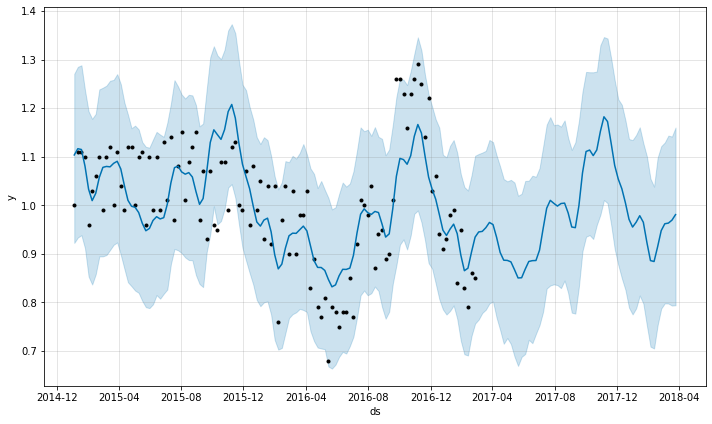

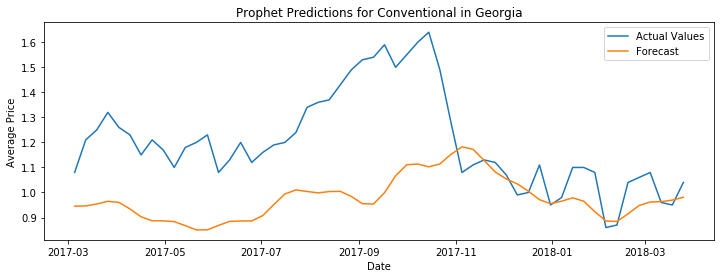

In [277]:
ga_con_prophet = Prophet(interval_width = 0.95, changepoint_prior_scale = 0.05).fit(con_ga_train)

future_con_ga = ga_con_prophet.make_future_dataframe(periods=56,freq = 'W')
forecast_con_ga = ga_con_prophet.predict(future_con_ga)

fig1_con_ga = ga_con_prophet.plot(forecast_con_ga)

preds_con_ga = forecast_con_ga.iloc[113:][['ds','yhat']].set_index('ds')

preds_con_ga_df = pd.concat([con_ga_test,preds_con_ga],axis = 1)
preds_con_ga_df.head()

error = np.sqrt(sum((preds_con_ga_df['y'] - preds_con_ga_df['yhat'])**2)/len(preds_con_ga_df))
print('RMSE in cents: ',error)

fig, ax = plt.subplots(figsize=(12,4))
ax1 = sns.lineplot(x=preds_con_ga_df.index, y=preds_con_ga_df['y'], label='Actual Values')
ax2 = sns.lineplot(x=preds_con_ga_df.index, y=preds_con_ga_df['yhat'], label='Forecast')

plt.ylabel('Average Price')
plt.xlabel('Date')
plt.title('Prophet Predictions for Conventional in Georgia')
# plt.savefig('Images/prophet_con_ca.png', dpi=300)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/opt/anaconda3/lib/python3.7/site-packages/pystan/misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



Text(0.5, 1.0, 'Prophet Predictions for Conventional in Georgia')

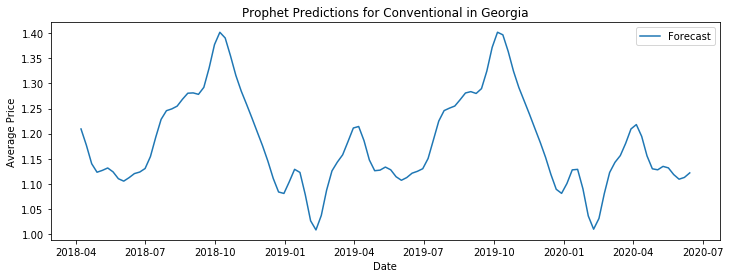

In [278]:
ga_con_prophet = Prophet(interval_width = 0.95, changepoint_prior_scale = 0.05).fit(ga_con)
future_con_ga = ga_con_prophet.make_future_dataframe(periods=116,freq = 'W')
forecast_con_ga = ga_con_prophet.predict(future_con_ga)

preds_con_ga = forecast_con_ga.iloc[170:][['ds','yhat']].set_index('ds')
preds_con_ga.head()

fig, ax = plt.subplots(figsize=(12,4))
ax2 = sns.lineplot(x=preds_con_ga.index, y=preds_con_ga['yhat'], label='Forecast')

plt.ylabel('Average Price')
plt.xlabel('Date')
plt.title('Prophet Predictions for Conventional in Georgia')
# plt.savefig('Images/prophet_con_ca.png', dpi=300)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/opt/anaconda3/lib/python3.7/site-packages/pystan/misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



Text(0.5, 1.0, 'Prophet Predictions for Hass Avocados in Georgia')

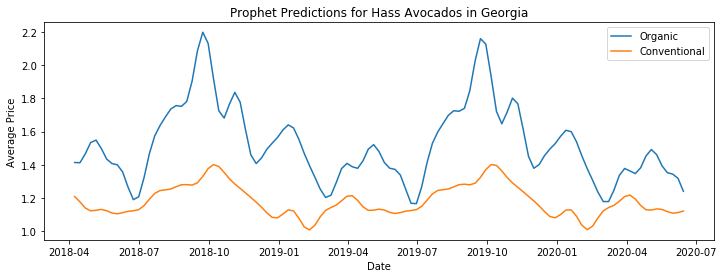

In [279]:
ga_org_prophet = Prophet(interval_width = 0.95, changepoint_prior_scale = 0.01).fit(ga_org)
future_org_ga = ga_org_prophet.make_future_dataframe(periods=116,freq = 'W')
forecast_org_ga = ga_org_prophet.predict(future_org_ga)

preds_org_ga = forecast_org_ga.iloc[170:][['ds','yhat']].set_index('ds')
fig, ax = plt.subplots(figsize=(12,4))
ax2 = sns.lineplot(x=preds_org_ga.index, y=preds_org_ga['yhat'], label='Organic')
ax1 = sns.lineplot(x=preds_con_ga.index, y=preds_con_ga['yhat'], label='Conventional')


plt.ylabel('Average Price')
plt.xlabel('Date')
plt.title('Prophet Predictions for Hass Avocados in Georgia')
# plt.savefig('Images/prophet_con_ca.png', dpi=300)

# Indiana

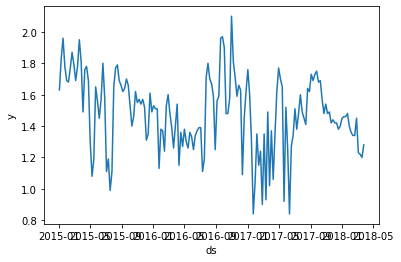

In [280]:
in_org = pd.DataFrame(organic[organic['region'] == 'IN'].groupby('Date')['AveragePrice'].mean())

in_org.reset_index('Date', inplace = True)
in_org.rename(columns = {'Date': 'ds', 'AveragePrice': 'y'}, inplace = True)

in_org['ds'] = pd.to_datetime(in_org['ds'], format='%Y-%m-%d')

sns.lineplot(x = in_org['ds'], y = in_org['y'])

In [281]:
# Train/Split
tss_in = TimeSeriesSplit(n_splits = 2)

X_org_in = in_org['ds'].values
y_org_in = in_org['y'].values

for train_index, test_index in tss_in.split(X_org_in):
#     print("TRAIN:", train_index, "TEST:", test_index)
    X_org_in_train, X_org_in_test = X_org_in[train_index], X_org_in[test_index]
    y_org_in_train, y_org_in_test = y_org_in[train_index], y_org_in[test_index]

org_in_train = pd.DataFrame(y_org_in_train,index = X_org_in_train, columns = ['y'])
org_in_test = pd.DataFrame(y_org_in_test, index = X_org_in_test, columns = ['y'])

org_in_train.reset_index(inplace = True)
org_in_train.rename(columns = {'index':'ds'},inplace = True)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/opt/anaconda3/lib/python3.7/site-packages/pystan/misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



RMSE in cents:  0.24945800047851127


Text(0.5, 1.0, 'Prophet Predictions for Organic in Indiana')

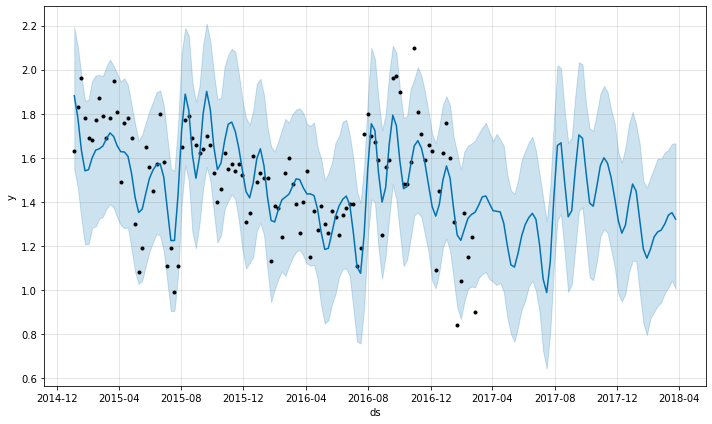

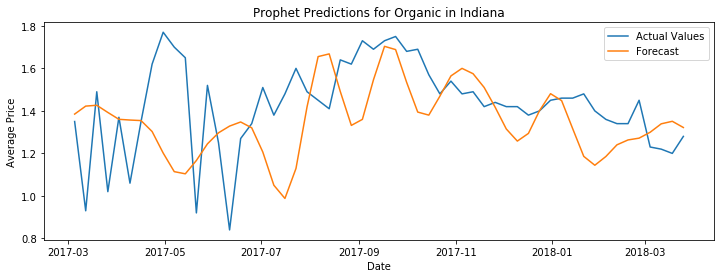

In [282]:
in_con_prophet = Prophet(interval_width = 0.95, changepoint_prior_scale = 0.05).fit(org_in_train)

future_org_in = in_con_prophet.make_future_dataframe(periods=56,freq = 'W')
forecast_org_in = in_con_prophet.predict(future_org_in)
fig1_org_in = in_con_prophet.plot(forecast_org_in)

preds_org_in = forecast_org_in.iloc[113:][['ds','yhat']].set_index('ds')

preds_org_in_df = pd.concat([org_in_test,preds_org_in],axis = 1)

error = np.sqrt(sum((preds_org_in_df['y'] - preds_org_in_df['yhat'])**2)/len(preds_org_in_df))
print('RMSE in cents: ',error)

fig, ax = plt.subplots(figsize=(12,4))
ax1 = sns.lineplot(x=preds_org_in_df.index, y=preds_org_in_df['y'], label='Actual Values')
ax2 = sns.lineplot(x=preds_org_in_df.index, y=preds_org_in_df['yhat'], label='Forecast')

plt.ylabel('Average Price')
plt.xlabel('Date')
plt.title('Prophet Predictions for Organic in Indiana')
# plt.savefig('Images/prophet_org.png', dpi=300)

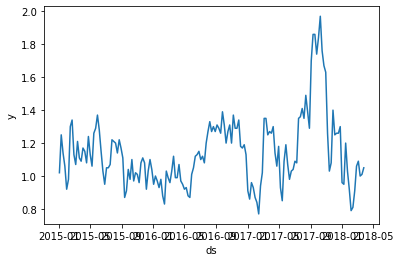

In [283]:
in_con = pd.DataFrame(conventional[conventional['region'] == 'IN'].groupby('Date')['AveragePrice'].mean())

in_con.reset_index('Date', inplace = True)
in_con.rename(columns = {'Date': 'ds', 'AveragePrice': 'y'}, inplace = True)

in_con['ds'] = pd.to_datetime(in_con['ds'], format='%Y-%m-%d')

sns.lineplot(x = in_con['ds'], y = in_con['y'])

In [284]:
# Train/Split
tss_in = TimeSeriesSplit(n_splits = 2)

X_con_in = in_con['ds'].values
y_con_in = in_con['y'].values

for train_index, test_index in tss_in.split(X_con_in):
#     print("TRAIN:", train_index, "TEST:", test_index)
    X_con_in_train, X_con_in_test = X_con_in[train_index], X_con_in[test_index]
    y_con_in_train, y_con_in_test = y_con_in[train_index], y_con_in[test_index]

con_in_train = pd.DataFrame(y_con_in_train,index = X_con_in_train, columns = ['y'])
con_in_test = pd.DataFrame(y_con_in_test, index = X_con_in_test, columns = ['y'])

con_in_train.reset_index(inplace = True)
con_in_train.rename(columns = {'index':'ds'},inplace = True)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/opt/anaconda3/lib/python3.7/site-packages/pystan/misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



RMSE in cents:  0.24981164474052475


Text(0.5, 1.0, 'Prophet Predictions for Conventional in Indiana')

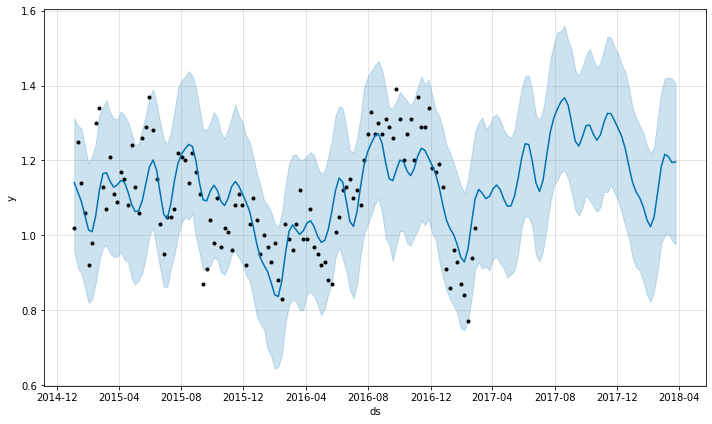

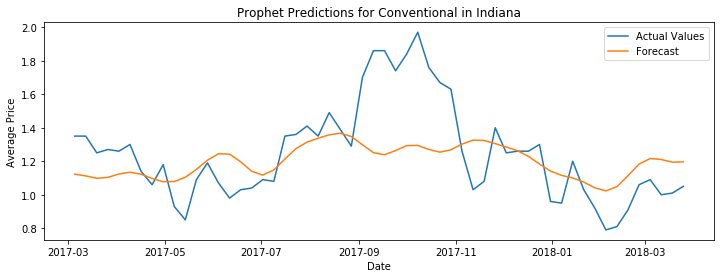

In [285]:
in_con_prophet = Prophet(interval_width = 0.95, changepoint_prior_scale = 0.05).fit(con_in_train)

future_con_in = in_con_prophet.make_future_dataframe(periods=56,freq = 'W')
forecast_con_in = in_con_prophet.predict(future_con_in)

fig1_con_in = in_con_prophet.plot(forecast_con_in)

preds_con_in = forecast_con_in.iloc[113:][['ds','yhat']].set_index('ds')
preds_con_in_df = pd.concat([con_in_test,preds_con_in],axis = 1)

error = np.sqrt(sum((preds_con_in_df['y'] - preds_con_in_df['yhat'])**2)/len(preds_con_in_df))
print('RMSE in cents: ',error)


fig, ax = plt.subplots(figsize=(12,4))
ax1 = sns.lineplot(x=preds_con_in_df.index, y=preds_con_in_df['y'], label='Actual Values')
ax2 = sns.lineplot(x=preds_con_in_df.index, y=preds_con_in_df['yhat'], label='Forecast')

plt.ylabel('Average Price')
plt.xlabel('Date')
plt.title('Prophet Predictions for Conventional in Indiana')
# plt.savefig('Images/prophet_con_ca.png', dpi=300)


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/opt/anaconda3/lib/python3.7/site-packages/pystan/misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



Text(0.5, 1.0, 'Prophet Predictions for Conventional in Indiana')

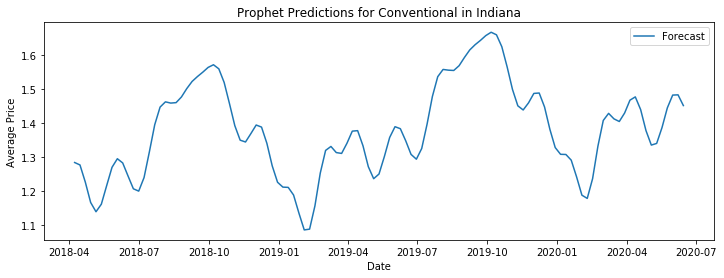

In [286]:
in_con_prophet = Prophet(interval_width = 0.95, changepoint_prior_scale = 0.05).fit(in_con)
future_con_in = in_con_prophet.make_future_dataframe(periods=116,freq = 'W')
forecast_con_in = in_con_prophet.predict(future_con_in)

preds_con_in = forecast_con_in.iloc[170:][['ds','yhat']].set_index('ds')

fig, ax = plt.subplots(figsize=(12,4))
ax2 = sns.lineplot(x=preds_con_in.index, y=preds_con_in['yhat'], label='Forecast')

plt.ylabel('Average Price')
plt.xlabel('Date')
plt.title('Prophet Predictions for Conventional in Indiana')
# plt.savefig('Images/prophet_con_ca.png', dpi=300)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/opt/anaconda3/lib/python3.7/site-packages/pystan/misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



Text(0.5, 1.0, 'Prophet Predictions for Hass Avocados in Indiana')

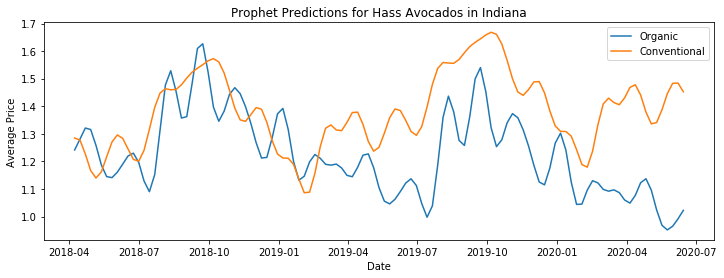

In [287]:
in_org_prophet = Prophet(interval_width = 0.95, changepoint_prior_scale = 0.01).fit(in_org)
future_org_in = in_org_prophet.make_future_dataframe(periods=116,freq = 'W')
forecast_org_in = in_org_prophet.predict(future_org_in)

preds_org_in = forecast_org_in.iloc[170:][['ds','yhat']].set_index('ds')

fig, ax = plt.subplots(figsize=(12,4))

ax2 = sns.lineplot(x=preds_org_in.index, y=preds_org_in['yhat'], label='Organic')
ax1 = sns.lineplot(x=preds_con_in.index, y=preds_con_in['yhat'], label='Conventional')


plt.ylabel('Average Price')
plt.xlabel('Date')
plt.title('Prophet Predictions for Hass Avocados in Indiana')
# plt.savefig('Images/prophet_con_ca.png', dpi=300)